# CROSS SECTIONAL ANALYSIS

In this notebook we will try to build a classifier which can answer our forst research question

### Question: Will an issued fine be paid shortly after?

In [98]:
# Load the "autoreload" extension
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

# add the 'src' directory as one where we can import modules
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src'))
sys.path.append(src_dir)

# self written packages
from data import data_utils
from data.preprocessing import preprocess

from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read files from directory of processed data tables

In [99]:
dfs = data_utils.read_csv_from_dir(dir_name="processed")

### Get all CaseIDs from create_fine events:

In [100]:
create_fine_activities_RAW = deepcopy(dfs[3])
create_fine_uid = set(create_fine_activities_RAW["T:concept:name"])
len(create_fine_uid)

150370

In [101]:
dfs[1].head()

,index,T:concept:name,E:concept:name,E:dismissal,E:lifecycle:transition,E:time:timestamp
0,17,A10001,Send Appeal to Prefecture,#,complete,9/24/07 12:00 AM
1,263,A10102,Send Appeal to Prefecture,#,complete,10/25/07 12:00 AM
2,276,A10107,Send Appeal to Prefecture,#,complete,9/24/07 12:00 AM
3,320,A10125,Send Appeal to Prefecture,NIL,complete,9/24/07 12:00 AM
4,574,A10236,Send Appeal to Prefecture,#,complete,10/2/07 12:00 AM


### Get all CaseIDs from payment events:

In [102]:
payment_activities_RAW = deepcopy(dfs[7])
payment_uid = set(payment_activities_RAW["T:concept:name"])

### Create union of both sets to get all cases which are common

In [103]:
# union of both events
create_to_payment_uid = payment_uid & create_fine_uid
len(create_to_payment_uid)

69715

### Delete all CaseIDs which are part of any other set

In [104]:
result_ids = create_to_payment_uid
for i in range(0,len(dfs)):
    if i not in [3,7]:
        helper = deepcopy(dfs[i])
        helper = set(helper["T:concept:name"])
        result_ids = result_ids - helper

### Amount of unique cases which only exist of create_fine and payment event

In [105]:
len(result_ids)

46383

### Add Column to create_fine data frame whcih holds the dependent variable (label)

In [106]:
data = create_fine_activities_RAW.set_index("T:concept:name")
data["label"] = 0
payment_indices = list(result_ids)
data.loc[payment_indices, "label"] = 1

In [107]:
data.head()

,index,E:amount,E:article,E:concept:name,E:dismissal,E:lifecycle:transition,E:org:resource,E:points,E:time:timestamp,E:vehicleClass,label
T:concept:name,,,,,,,,,,,
A1,0,35.0,157.0,Create Fine,NIL,complete,561.0,0.0,7/24/06 12:00 AM,A,0
A100,2,35.0,157.0,Create Fine,NIL,complete,561.0,0.0,8/2/06 12:00 AM,A,0
A10000,7,36.0,157.0,Create Fine,NIL,complete,561.0,0.0,3/9/07 12:00 AM,A,0
A10001,12,36.0,157.0,Create Fine,NIL,complete,537.0,0.0,3/19/07 12:00 AM,A,0
A10004,18,36.0,157.0,Create Fine,NIL,complete,537.0,0.0,3/20/07 12:00 AM,A,0


## Definition of the E:dismissal variable:
Dismissal contains a character that encodes the diverse reasons for a possible dismissal of the fine. A value of NIL encodes that the fine is not dismissed (i.e. has to be paid) any other value encodes different motivations.

### Redesign feature E:dismissal so that 1 encodes has to be paid & 0 encodes the opposite

In [108]:
data["dismissal"] = 0
dismissal_nil_indices = list(data[data["E:dismissal"]=='NIL'].index)
data.loc[dismissal_nil_indices, "dismissal"] = 1
data = data.drop('E:dismissal', axis=1)
data.reset_index(inplace=True)

In [109]:
data.head()

,T:concept:name,index,E:amount,E:article,E:concept:name,E:lifecycle:transition,E:org:resource,E:points,E:time:timestamp,E:vehicleClass,label,dismissal
0,A1,0,35.0,157.0,Create Fine,complete,561.0,0.0,7/24/06 12:00 AM,A,0,1
1,A100,2,35.0,157.0,Create Fine,complete,561.0,0.0,8/2/06 12:00 AM,A,0,1
2,A10000,7,36.0,157.0,Create Fine,complete,561.0,0.0,3/9/07 12:00 AM,A,0,1
3,A10001,12,36.0,157.0,Create Fine,complete,537.0,0.0,3/19/07 12:00 AM,A,0,1
4,A10004,18,36.0,157.0,Create Fine,complete,537.0,0.0,3/20/07 12:00 AM,A,0,1


### Prepare dataframe for classification

In [110]:
# drop unnecessary columns
not_used_columns = ['label','index', 'E:org:resource','T:concept:name','E:concept:name', 'E:lifecycle:transition', 'E:time:timestamp']

# target variable
target_column = data["label"] 

cleaned_features = data.drop(not_used_columns, axis = 1)

In [111]:
len(target_column[target_column==0])

103987

In [112]:
cleaned_features.head()

,E:amount,E:article,E:points,E:vehicleClass,dismissal
0,35.0,157.0,0.0,A,1
1,35.0,157.0,0.0,A,1
2,36.0,157.0,0.0,A,1
3,36.0,157.0,0.0,A,1
4,36.0,157.0,0.0,A,1


### Create dummy feature out of E:vehicleClass

In [113]:
dummies = ['E:vehicleClass']

for dummy in dummies:
    features_with_dummy = pd.get_dummies(cleaned_features[dummy]).rename(columns=lambda x: dummy + '_' + str(x))
    cleaned_features = pd.concat([cleaned_features, features_with_dummy], axis=1)
    cleaned_features = cleaned_features.drop([dummy], axis=1)

In [114]:
cleaned_features.head()

,E:amount,E:article,E:points,dismissal,E:vehicleClass_A,E:vehicleClass_C,E:vehicleClass_M,E:vehicleClass_R
0,35.0,157.0,0.0,1,1,0,0,0
1,35.0,157.0,0.0,1,1,0,0,0
2,36.0,157.0,0.0,1,1,0,0,0
3,36.0,157.0,0.0,1,1,0,0,0
4,36.0,157.0,0.0,1,1,0,0,0


In [153]:
cleaned_features.describe()

,E:amount,E:article,E:points,dismissal,E:vehicleClass_A,E:vehicleClass_C,E:vehicleClass_M,E:vehicleClass_R
count,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000,150370.000000
mean,44.715380,113.246658,0.078879,0.996648,0.975673,0.016333,0.007967,0.000027
std,49.416618,68.219475,0.577687,0.057797,0.154062,0.126753,0.088902,0.005158
min,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.800000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,35.000000,157.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,38.000000,157.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,4351.000000,401.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Define parameters for Random Forest & seed for reproducability

In [141]:
seed_num = 42
parameters = {'n_estimators':np.arange(2,30,step=2), 'criterion':('gini', 'entropy')}

### Create Train/Test Split

In [142]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_features, target_column, test_size=0.33, random_state=seed_num)

### Perform Gridsearch with Crossvalidation for Random Forest

In [143]:
# create random forest classifier and perform grid search with cross validation
rf = RandomForestClassifier(random_state=seed_num)
clf = GridSearchCV(rf, parameters,cv=10)
clf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ('gini', 'entropy'), 'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Get best parameter combination

In [144]:
bp = clf.best_params_
bp

{'criterion': 'gini', 'n_estimators': 14}

### Apply parameters to Random forest

In [145]:
rf_with_best_params = RandomForestClassifier(n_estimators=bp['n_estimators'], criterion=bp['criterion'],random_state=seed_num)

### Rerun model with parameters

In [146]:
# fit model onto train set
rf_with_best_params.fit(X_train,y_train)
# predict labels
rf_with_best_params_pred = clf.predict(X_test)
# predict probabilities
rf_with_best_params_probs = clf.predict_proba(X_test)

### Accuracy Score

In [147]:
accuracy_score(y_test, rf_with_best_params_pred)

0.69548394897527355

In [148]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_with_best_params_pred)
roc_auc = auc(fpr, tpr)

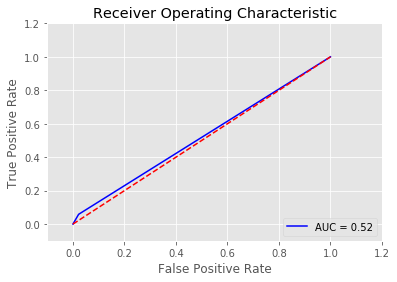

In [149]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()